# [SWCON253] Machine Learning
Teaching Assistant: HyunDong Cho (gusehd1113@khu.ac.kr)

Professor: Jinwoo Choi (jinwoochoi@khu.ac.kr)

---

# P3:  Deep Learning Framwork: Pytorch를 이용하여 MLP 구현 (10점)

### 학습목표
- pytorch를 사용하여 구현된 MLP 구조를 이해하고 수정할수 있다.
- Fashinon-MNIST 문제를 스스로 해결하면서 딥러닝 학습과정을 이해하고 하이퍼파라미터를 튜닝을 할 수 있다.

### 실습내용
pytorch를 사용하여 구현 되어 있는 MLP를 통해 Fashion-MNIST 데이터셋을 분류하는 classfier를 학습합니다.

실습은 다음 순서로 진행됩니다.
- 1) Fashon-MNIST 데이터셋 설명
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

아래 코드에는 2개의 퍼셉트론은 이용한 MLP 모델이 정의 되어 있습니다.
실습을 시작하기전에 이 노트북 파일을 읽고 모든 셀을 실행해하여 올바르게 작동하는지 확인하세요.<br>
이후에 아키텍쳐를 마음껏 변경하여 최고의 성능이 나오도록 수정해 보세요.

**1. 다음은 변경 가능한 부분입니다.**
- activation 함수 (logistic sigmoid, tanh, relu, leaky relu, ...)
- learning rate
- hidden layers 갯수
- epochs
- minibatch size
- 각 hidden layer의 neuron 개수

**2. 그러나 다음 사항은 변경하지 마세요.**
- 가중치 초기화 방법
- 랜덤시드
- 최적화 방법, 학습 방법

**3. layer를 추가하여 2개 이상의 hidden layer를 구성할 수 있게 구현하세요.**

**4. 수정가능한 셀은 아래 주석으로 확실하게 하이라이트되어 표시되어 있습니다.**

```
############################################################
# 변경 가능한 셀
############################################################
```

### 점수
**Test set 기준**

- 정확도 85% 이상 2점
- 정확도 86% 이상 4점
- 정확도 87% 이상 6점
- 정확도 88% 이상 8점

**구현**
- Layer 수 2개 이상으로 구현: 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [3]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [44]:
# 이 부분은 절대 변경하지 마세요.

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [6]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [7]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번 실습에서는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [8]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번 실습에서는 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [46]:
############################################################
# 변경 가능한 셀
############################################################

# BATCH_SIZE = 60000을 사용하면 Full-Batch 학습
# BATCH_SIZE = 1을 사용하면 Online 학습
# BATCH_SIZE = N (1 < N < 60000) 을 사용하면 Mini-batch 학습
BATCH_SIZE = 64

In [47]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

특히, Label data의 경우 One-hot vector encoding 되기 전의 형태의 class label 정보입니다.

In [48]:
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        print(f'Image data shape: \t {x.shape}')
        print(f'Label data shape: \t {y.shape}')
        print(y)
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
Image data shape: 	 torch.Size([64, 1, 28, 28])
Label data shape: 	 torch.Size([64])
tensor([5, 1, 4, 8, 9, 9, 7, 5, 9, 6, 8, 8, 8, 8, 8, 4, 5, 8, 5, 2, 6, 9, 5, 1,
        9, 4, 1, 8, 4, 7, 8, 6, 4, 7, 3, 1, 5, 6, 1, 1, 6, 7, 0, 4, 3, 9, 7, 4,
        7, 4, 8, 9, 1, 1, 7, 8, 0, 3, 2, 0, 5, 0, 6, 8])


## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [50]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes # 10 
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        ########## <your code> to add layer #############
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out = self.linear_1(x)
        out = torch.relu(out)
        
        ########### <your code> to set the layer and the activation function #########
        out = self.linear_2(out)
        out = torch.relu(out)
        
        
        logits = self.linear_out(out)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        # 다만, 이후 사용할 F.cross_entropy() 함수 내부에 softmax가 이미 구현되어 있기 때문에
        # Loss function 계산 시에는 self.softmax()를 통과하기 전의 logits 값을 이용하게 됩니다.
        probas = self.softmax(logits)
        return logits, probas

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 이 과제에서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4) Training

**Cross entropy loss function 사용 시 주의점**

- 모델의 출력인 logits, probas의 차원은 [BATCH_SIZE, num_classes] 형태지만, 정답 Label인 targets 변수의 차원은 [BATCH_SIZE] 입니다. (ex, [1, 3, 2, 4, 9, ..., 3])


- 일반적으로 Cross Entropy Loss를 계산하기 위해서는 targets에 one-hot vector encoding을 수행해주어야 하지만, F.cross_entropy() 함수는 이를 내부적으로 수행해줍니다.


- 또한, F.cross_entropy() 함수 내부적으로 softmax 함수를 이용하기 때문에, 모델의 출력 중 probas 값이 아닌 logits 값을 이용하여 Loss function을 계산합니다.


- 구현 상세는 pytorch documents에서 확인할 수 있습니다. (https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy)

In [53]:
############################################################
# 변경 가능한 셀
############################################################

### num_hidden_1, num_hidden_2 변경 가능, 
### 레이어를 더 추가하고 싶다면 이부분을 알맞게 수정하세요.
model = MLP(num_features=28*28,
            num_hidden_1=128,
            num_hidden_2=64,
            num_classes=10)

model = model.to(DEVICE)


### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않습니다. 
### 그러나 Learning Rate(lr)는 변경이 가능합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

NUM_EPOCHS = 10 # 변경 가능
############################################################

### 아래는 변경 불가능
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        
        # Loss 계산 시에는 logits 이용
        cross_entropy += F.cross_entropy(logits, targets).item()
        
        # 추론 시에는 probas 이용
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.cpu().float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/937 | Cost: 2.3115
Epoch: 001/010 | Batch 040/937 | Cost: 0.9904
Epoch: 001/010 | Batch 080/937 | Cost: 0.6759
Epoch: 001/010 | Batch 120/937 | Cost: 0.8622
Epoch: 001/010 | Batch 160/937 | Cost: 0.6779
Epoch: 001/010 | Batch 200/937 | Cost: 0.4220
Epoch: 001/010 | Batch 240/937 | Cost: 0.6426
Epoch: 001/010 | Batch 280/937 | Cost: 0.6475
Epoch: 001/010 | Batch 320/937 | Cost: 0.7499
Epoch: 001/010 | Batch 360/937 | Cost: 0.4407
Epoch: 001/010 | Batch 400/937 | Cost: 0.5869
Epoch: 001/010 | Batch 440/937 | Cost: 0.3580
Epoch: 001/010 | Batch 480/937 | Cost: 0.7258
Epoch: 001/010 | Batch 520/937 | Cost: 0.5809
Epoch: 001/010 | Batch 560/937 | Cost: 0.5012
Epoch: 001/010 | Batch 600/937 | Cost: 0.3107
Epoch: 001/010 | Batch 640/937 | Cost: 0.6317
Epoch: 001/010 | Batch 680/937 | Cost: 0.6394
Epoch: 001/010 | Batch 720/937 | Cost: 0.4311
Epoch: 001/010 | Batch 760/937 | Cost: 0.5878
Epoch: 001/010 | Batch 800/937 | Cost: 0.3700
Epoch: 001/010 | Batch 840/937 | C

## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

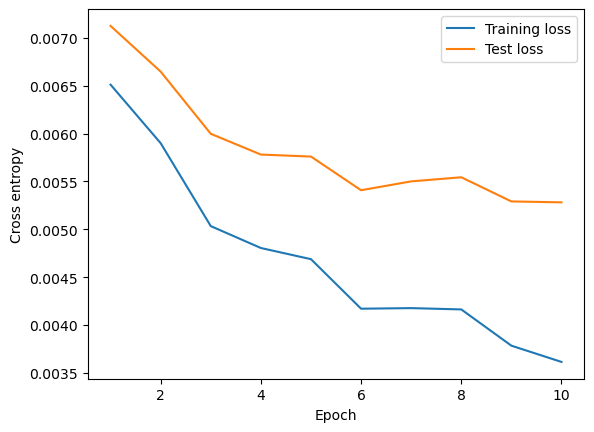

In [54]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

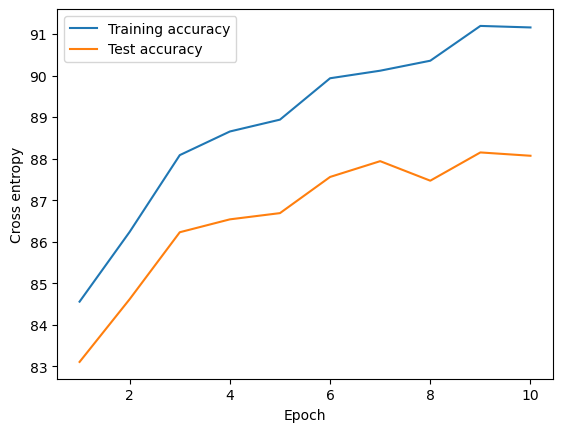

In [55]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [56]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.07%


## 6) Discussion

**1) 학습, 테스트 정확도는 얼마인가요? (위 숫자를 복사하세요.)**

- Training: 91.16%
- Test    : 88.07%

**2) overfitting을 경험했나요? 만약 그랬다면 왜 그랬을지 적어보고, overfitting을 방지하기위한 간단한 방법은 무엇일까요?**

[제안하는 방법 적기]
overfitting을 경험했습니다. 
초기 낮은 epoch 설정에서는 눈에 띄는 overfitting을 경험하기 어려웠습니다. 하지만 epoch를 10 이상으로 늘려 학습을 진행하면서, 학습 정확도(Training Accuracy)는 계속해서 높아지는 반면, 테스트 정확도(Test Accuracy)는 어느 시점부터 오르지 않거나 미세하게 떨어지는 현상이 나타났습니다. 

원인: 모델이 너무 복잡하거나 학습을 너무 많이 진행하여, 훈련 데이터에만 존재하는 특성이나 노이즈까지 '암기'해버렸기 때문입니다. 이렇게 되면 모델이 새로운 데이터(테스트 데이터)에 대한 일반적인 패턴을 잃어버려 성능이 떨어지게 됩니다.

이 실습에서는 overfitting을 피하기 위해
너무 큰 epoch 대신 10을 epoch를 사용
learning rate를 0.1로 변경
activation 함수로 relu 사용했습니다.

overfitting 방지를 위한 이론적인 방법으로는,
1. 조기 종료 (Early Stopping): 테스트 정확도가 더 이상 오르지 않고 정체되거나 떨어지기 시작하는 시점에서 훈련을 멈추는 방법입니다. 가장 간단하고 효과적인 방법 중 하나입니다. 
2. 드롭아웃 (Dropout): 훈련 과정에서 각 레이어의 뉴런 중 일부를 무작위로 비활성화하는 기법입니다. 이는 모델이 특정 뉴런에 과도하게 의존하는 것을 막아 더 강건한(robust) 특징을 학습하도록 강제합니다.
3. 정규화 (Regularization): 모델의 가중치가 너무 커지지 않도록 손실 함수(loss function)에 페널티(penalty) 항을 추가하는 방법입니다. (예: L1, L2 정규화) 이는 모델의 복잡도를 낮추는 효과가 있습니다.



예를 들면, 

- batch size를 256으로 변경
- 두개의 hidden layers의 activation을 relu로 변경
- learning rate를 0.2로 변경

**3) 만약 hidden layer 수가 늘어나면(3개 이상) 얻을 수 있는 장/단점은 무엇일까요?**

[답변작성] 
장점:
1. 더 높은 표현력(Expressiveness): 깊어진 모델은 더 복잡하고 추상적인 특징을 학습할 수 있습니다.
   예를 들어, 첫 번째 층이 이미지의 선이나 모서리를 학습하면, 다음 층은 이를 조합하여 눈, 코, 입 같은 형태를 학습하고, 더 깊은 층은 얼굴 전체를 인식하는 것처럼 계층적인 학습이 가능해집니다. 이를 통해 더 어려운 문제를 풀 수 있고, 잠재적으로 더 높은 정확도를 달성할 수 있습니다.

단점:
1. 기울기 소실or폭주 (Vanishing/Exploding Gradient): 층이 매우 깊어지면 역전파 과정에서 기울기가 너무 작아지거나 커져서 학습이 불안정해지거나 멈출 수 있습니다. (ReLU와 같은 활성화 함수가 이를 완화해 줍니다.)
2. Overfitting 위험 증가: 모델의 복잡도가 증가하여 훈련 데이터를 과도하게 암기할 위험이 커집니다.
3. 학습 시간 증가: 계산량이 늘어나므로 모델을 훈련시키는 데 더 많은 시간이 소요됩니다.

**4) 구현하면서 수정한 부분에 대해 작성하여 수정한 이유 및 성능향상이 생긴 이유에 대해 답해보세요.**

[답변작성]
learning rate  1 -> 0.1
num_hidden_1   10-> 128
num_hidden_2   10-> 64
epoch 2-> 10 
activation 함수 relu로 변경

활성화 함수 변경 (Sigmoid → ReLU)
수정 이유: Sigmoid 함수는 기울기 소실 문제 때문에 깊은 신경망의 학습을 저해하는 원인이 될 수 있습니다.
성능 향상 이유: ReLU 함수로 변경함으로써 기울기 소실 문제를 방지하고, 더 빠르고 안정적인 학습이 가능해졌습니다. 이는 성능 개선에 가장 결정적인 역할을 했습니다.

은닉층 뉴런 수 증가 (10/10 → 128/64)
수정 이유: 초기 뉴런 수 10개는 FashionMNIST 이미지의 복잡한 특징을 학습하기에 턱없이 부족한 용량이었습니다.
성능 향상 이유: 뉴런 수를 대폭 늘려 모델의 표현력을 키웠습니다. 784 -> 128 -> 64 -> 10과 같이 점진적으로 차원을 줄이는 '깔때기' 구조를 만들어, 정보 손실을 최소화하면서, 병목 현상을 줄이고 효율적으로 특징을 압축하도록 설계했습니다.

learning rate 수정 (1 → 0.1)
수정 이유: 초기 학습률 1은 너무 커서 학습이 불안정하고 최적점을 찾기 어려웠습니다. Cost 값이 줄어들다 갑자기 튀는 현상이 이를 증명합니다.
성능 향상 이유: 학습률을 0.1로 낮춤으로써, 모델이 손실 함수의 경사를 따라 보다 안정적이고 세밀하게 최적의 가중치를 찾아갈 수 있게 되었습니다.

에포크 수 증가 (2 → 10)
수정 이유: 단 2번의 에포크는 모델이 전체 데이터를 충분히 학습하기에 너무 짧은 시간이었습니다.
성능 향상 이유: 학습 횟수를 10회로 늘려, 모델이 데이터의 패턴을 충분히 반복 학습하고 가중치를 미세 조정할 시간을 확보해주었습니다.